[Past results](https://atmos.washington.edu/~nbren12/reports/uwnet/notebooks/2019-04-16-couple-wave-to-source.html) had two coding errors:

1. SOLIN=500 * 1000 Wm2 was used. As part of the initial debugging process, I had made this value arbitrarily large.
2. A gravity of 1/ms^2 rather than 9.81 was used.

This notebook corrects these errors and studies the sensitivity of the linearized wave results to the diurnal cycle. The main conclusions are

1. The unstable propagating mode now has a phase speed of 20 m/s, and a different vertical structure. In general, the waves all have more realistic phase speeds.
2. The growth rates are sensitive to SOLIN

# Diurnal Cycle

The results are very sensitive to the SOLIN input. To treat this properly I should marginalize the data over the inputs.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from uwnet.wave import get_wave_from_training_data, model_plus_damping
from uwnet.wave import marginize_model_over_solin, WaveEq, model_plus_damping, wave_from_xarray
import torch
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from uwnet import thermo
from src.data import open_data

def eval_diurnal_cycle(model, diurnal):

    expanded = diurnal.rename({'time_of_day': 'time'}).expand_dims(['y', 'x'], [-2, -1])
    return model.call_with_xr(expanded).rename({'time': 'time_of_day'}).squeeze()
    
def plot_profile_tod(a):

    plt.figure(figsize=(2,5))

    cm = plt.cm.viridis(a.time_of_day)
    for i in range(len(cm)):
        plt.plot(a[i], diurnal.z, c=cm[i], label=float(a.time_of_day[i]*24))
    plt.legend(bbox_to_anchor=(1,1))
    
    
def marginalize_over_tod(model, base_state, solin):
    """Compute output of the model for fixed base but varying insolation"""
    base_state_repeat = xr.concat([base_state]*len(solin), dim=solin.time_of_day)\
    .assign(SOLIN=solin)
    
    return eval_diurnal_cycle(model, base_state_repeat)


def eval_profile(model, x):
    y = x.expand_dims(['y', 'x'], [-2, -1])
    z = model.call_with_xr(y)
    return z.squeeze()

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
ds = open_data('training')
model = torch.load("../models/268/5.pkl")
mean = ds.isel(y=slice(28, 34)).mean(['x', 'y'])
mean['time_of_day'] = mean['time'] % 1

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'uwnet.normalization.Scaler' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ParameterDict' has changed. you can retrieve the or

# Diurnal cycle of basic fields

In [3]:
diurnal = mean.groupby('time_of_day').mean('time')
diurnal_anom = diurnal - diurnal.mean('time_of_day')

The diuranl cycle in humidity is small:

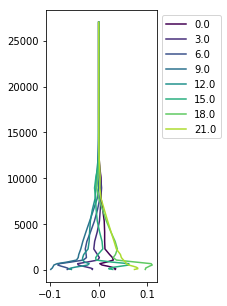

In [4]:
plot_profile_tod(diurnal_anom.QT)

the cycle in temperature seems a little more significant:

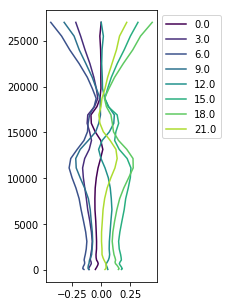

In [5]:
plot_profile_tod(diurnal_anom.SLI)

Obviously, the cycle of solar insolation is the most important:

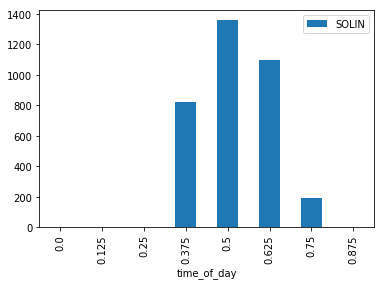

In [6]:
diurnal.SOLIN.to_dataframe().plot(kind='bar')

## Cycle of Heating/moistening

In [7]:
srcs = eval_diurnal_cycle(model, diurnal)

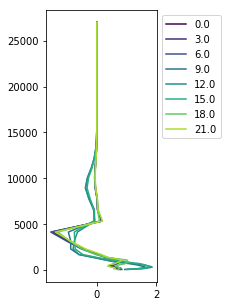

In [8]:
plot_profile_tod(srcs['QT'])

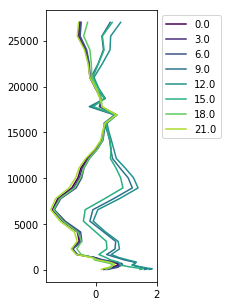

In [9]:
plot_profile_tod(srcs['SLI'])

There is a fairly significant diurnal cycle of heating.

## Commutivity of diurnal cycle averaging

Does the NN depend on covariance between SOLIN and SLI to produce its diurnal cycle? We now evaluate the input of the neural network given fixed QT, SLI, and SST, but the diurnal cycle of SOLIN

In [10]:
base_state = diurnal.mean('time_of_day')

In [11]:
srcs = marginalize_over_tod(model, base_state, diurnal.SOLIN)

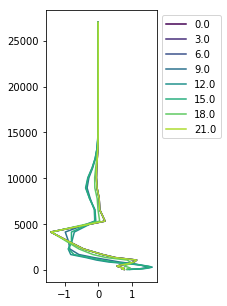

In [12]:
plot_profile_tod(srcs['QT'])

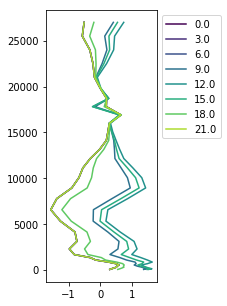

In [13]:
plot_profile_tod(srcs['SLI'])

These plots look similar to the above plots, so we should be able to marginalize out the diurnal cycle while using an otherwise fixed base state.

# Plug into wave.py
I now just need to implement this in the existing infrastructure. This should be doable by simply modifying the `source_fn` attribute of `WaveEq`.

In [14]:
solin = torch.tensor(diurnal.SOLIN.values)
model_marginalized = marginize_model_over_solin(model, solin)
src = model_plus_damping(model_marginalized)

src_original = model_plus_damping(model)


base_state['SOLIN'] = 800.0
wave = wave_from_xarray(base_state, src=src_original)

base_state['SOLIN'] = 1400.0
wave1400 = wave_from_xarray(base_state, src=src_original)

wave_marginal = wave_from_xarray(base_state, src)


def plot_unstable_specta(wave):
    fig, (a, b) = plt.subplots(1, 2)
    
    
    k, As =  wave.matrices()

    l, r =np.linalg.eig(As)

    a.semilogx(2*np.pi/k/1e3, l.real, '.');
    a.set_ylim(bottom=0)

    c = l.imag/k[:, np.newaxis]

    b.plot(c, '.');
    b.set_ylim(bottom=0)
    
    solin = wave.base_state['SOLIN'].item()
    fig.suptitle(f'SOLIN = {solin} W/m2')
    a.set_title('Growth rate')
    b.set_title('Phase Speed')

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


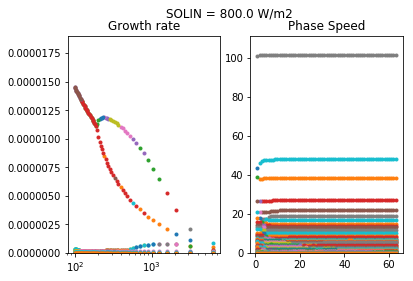

In [15]:
plot_unstable_specta(wave)

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


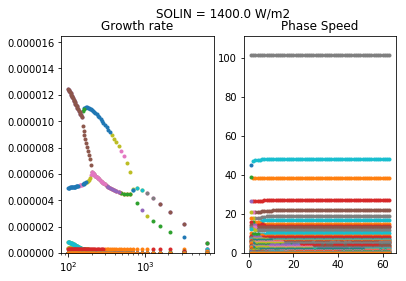

In [16]:
plot_unstable_specta(wave1400)

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0.98, 'SOLIN Marginalized outs')

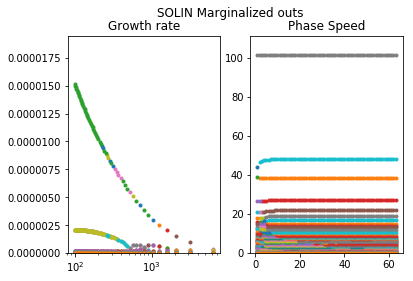

In [17]:
plot_unstable_specta(wave_marginal)
plt.gcf().suptitle("SOLIN Marginalized outs")

As you can see wee, get different answer for different values of SOLIN, and for the marginalized solution.

# Propagating instability for SOLIN=800

In [23]:
from uwnet.wave import plot_struct_2d


k=2*np.pi/5000e3
lam, r = wave.get_eigen_pair(k=k)

eig = xr.Dataset({'lam': (['m'], lam), 'r':(['f', 'm'], r)}, coords={'k': k, 'm': np.arange(len(lam))})

eig['cp'] = eig.lam.imag/eig.k
eig['gr'] = eig.lam.real

eig.cp[(eig.cp > 0) & (eig.gr > 0)]

<xarray.DataArray 'cp' (m: 8)>
array([20.746133, 17.80821 ,  6.338018,  4.952627,  4.310905,  0.637357,
        0.728837,  0.286029])
Coordinates:
    k        float64 1.257e-06
  * m        (m) int64 29 31 55 61 63 82 84 92

<xarray.DataArray 'cp' ()>
array(20.746133)
Coordinates:
    k        float64 1.257e-06
    m        int64 29
<xarray.DataArray 'gr' ()>
array(2.152182e-08, dtype=float32)
Coordinates:
    k        float64 1.257e-06
    m        int64 29


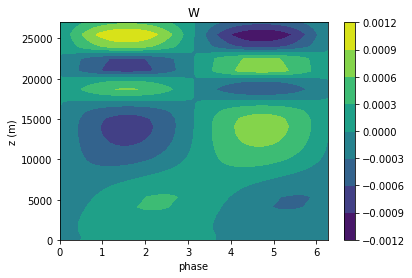

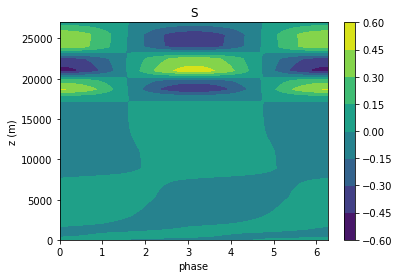

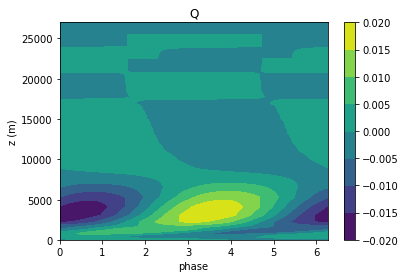

In [22]:
i = 29


print(eig.cp[i])
print(eig.gr[i])

w, s, q = np.split(eig.r.isel(m=i), 3)


plt.figure()
plt.title('W')
plot_struct_2d(w.values, mean.z.values)
plt.colorbar()

plt.figure()
plt.title('S')
plot_struct_2d(s.values, mean.z.values)
plt.colorbar()

plt.figure()
plt.title('Q')
plot_struct_2d(q.values, mean.z.values)
plt.colorbar()
